Notebook to optimize prophet model

In [97]:
# create prophet model
import pandas as pd
import yfinance as yf
from datetime import datetime
from datetime import timedelta
from pandas.tseries.offsets import BDay
import random
import math
import numpy as np
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from scipy.stats import norm
import plotly.graph_objects as go
import warnings

warnings.filterwarnings('ignore')

today = datetime.today().strftime('%Y-%m-%d')
start = '2018-06-01'

sp_df = yf.download('^GSPC', start, today)
sp_df.reset_index(inplace = True)

df = sp_df[['Date', 'Adj Close']]
df.rename(columns = {'Date' : 'ds', 'Adj Close' : 'y'}, inplace = True)

[*********************100%***********************]  1 of 1 completed


In [98]:
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x = df['ds'], y = df['y']))

fig1.update_layout(
    title_text = "S&P 500 Pricing with Prophet"
)

# adding sliders and buttons for interaction
fig1.update_layout(
    xaxis = dict(
        rangeselector = dict(
            buttons = list([
                dict(
                    count = 1,
                    label = '1m',
                    step = 'month',
                    stepmode = 'backward'
                ),
                dict(
                    count = 6,
                    label = '6m',
                    step = 'month',
                    stepmode = 'backward'
                ),
                dict(
                    count = 1,
                    label = 'YTD',
                    step = 'year',
                    stepmode = 'todate'
                ),
                dict(
                    count = 1,
                    label = '1y',
                    step = 'year',
                    stepmode = 'backward'
                ),
                dict(
                    count = 5,
                    label = '5y',
                    step = 'year',
                    stepmode = 'backward'
                ),
                dict(step = 'all')
            ])
        ),
        rangeslider = dict(
            visible =True
        ),
        type = 'date'
    )
)

fig1.show()

In [99]:
m = Prophet(daily_seasonality = False, seasonality_mode='multiplicative', changepoint_prior_scale=0.5)
for col in df.columns:
    if col not in ['ds', 'y'] and not 'Close':
        m.add_regressor(col, mode = 'additive')
m.fit(df)

future = m.make_future_dataframe(periods = 365)
business_days = BDay().onOffset
filter = pd.to_datetime(future['ds']).map(business_days)
future = future[filter]
forecast = m.predict(future)
plot_plotly(m, forecast)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


Let's assess the changepoints and see if we need to add any important ones.

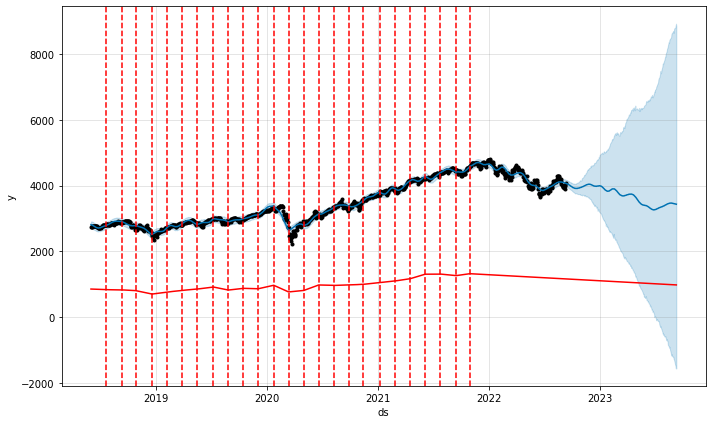

In [100]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

We're actually limited! This is because prophet only places changepoints within the first 80% of the time-series. In our final model, we could use a different changepoint phase to account for recent, large-scale, economic events. Next, let's do some parameter hypertuning.

In [101]:
import itertools
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

param_grid = {  
    'changepoint_prior_scale': [10, 100, 1000, 10000, 100000],
    'seasonality_prior_scale': [0.001, 0.01, 0.1],
    'changepoint_range': [0.75, 0.8, 0.85, 0.9],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m1 = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m1, initial = '780 days', period = '180 days', horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 5 forecasts with cutoffs between 2020-08-20 00:00:00 and 2022-08-10 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fada99f0bb0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 5 forecasts with cutoffs between 2020-08-20 00:00:00 and 2022-08-10 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fadfb187d60>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 5 forecasts with cutoffs between 2020-08-20 00:00:00 and 2022-08-10 00:00:00
INFO:p

In [102]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 1000, 'seasonality_prior_scale': 0.01, 'changepoint_range': 0.85}


And above we have our parameters that optimize the model to the best of our ability.